### 1 - Importing packages

In [1]:
#Pacotes Básicos Python
import os
import string
import itertools
from collections import defaultdict, Counter

#Banco de Dados sqlite3
import sqlite3

#NLTK - Natural Languange Toolkit
import nltk

#Pacotes de Suporte - pandas e numpy
import pandas as pd
import numpy as np

#Machine Learning
from scipy.sparse import csr_matrix,coo_matrix,hstack
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn import preprocessing #normalização dos dados
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score
from sklearn import cross_validation

#Machine Learning - estimators
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

#Visualização de dados
import matplotlib.pyplot as plt

#Enchant - Correção Ortográfica
import enchant
from enchant import DictWithPWL
from enchant.checker import SpellChecker

#Persistência de Modelo
from sklearn.externals import joblib

#Contagem de tempo de processamento
from time import time

/home/gus/py3env/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 2 - Pré-Processamento

In [5]:
#DROP
db = sqlite3.connect('projeto.db')
querySQL = db.execute("DROP TABLE PESQUISA")
db.commit()
db.close()

In [6]:
#CREATE TABLE
#Comando para criar a tabela no banco de dados. Só precisa ser executada uma única vez

db = sqlite3.connect('projeto.db')
db.execute('''CREATE TABLE PESQUISA
       (ID INT PRIMARY KEY    NOT NULL,
       IDINC           CHAR(20),
       DATA            DATE,
       COMENTARIO      TEXT,
       NOTA1           FLOAT,
       NOTA2           FLOAT,
       NIVEL1          TEXT,
       MANIFESTACAO    CHAR(20),
       MANIFATEN       CHAR(20),
       MANIFSERV       CHAR(20));''')
db.close()

In [2]:
#MaxID
db = sqlite3.connect('projeto.db')
cursor = db.execute('SELECT max(ID) FROM PESQUISA')
MaxID = cursor.fetchone()[0]

try:
    val = int(MaxID)
except:
    MaxID=0
    
print(MaxID)
db.close()

99825


In [3]:
#Função para identificar o idioma da pesquisa de satisfação, baseada no idioma da Questão1
#Input : dataframe e Questão1 
#Output: inteiro com a codificação do idioma. 1-Portugês, 2-Espanhol, 3-Inglês ou outros
def setidioma (DF,Q):
    if Q == "Qual o seu nível de satisfação com esse atendimento?":
        return 1
    elif Q == "¿Cuál es su grado de satisfacción con este servicio?":
        return 2
    else:
        return 3

In [4]:
#Função para normalizar o campo 'Manifestação' em: elogio, neutro e reclamação.
#Input : dataframe e campos de MANIFESTAÇÃO AO ATENDIMENTO e MANIFESTAÇÃO AO SERVIÇO 
#Output: MANIFESTAÇÃO normalizada
def setmanifestacao (DF,ATEN,SERV):
    positivo=["elogio","agradecimento"]
    neutro  =["neutro","sugestão"]
    negativo=["reclamação","insatisfeito","não-resolvido"]
    valido=positivo+neutro+negativo

    if   (str.lower(ATEN) in negativo) or (str.lower(SERV) in negativo):
        return "reclamação"
    elif (str.lower(ATEN) in positivo) or (str.lower(SERV) in positivo):
        return "elogio"
    elif (str.lower(ATEN) in neutro) and (str.lower(SERV) in neutro):
        return "neutro"
    elif (str.lower(ATEN) not in valido) or (str.lower(SERV) not in valido):
        return "invalido"
    else:
        return "erro"

In [5]:
#Função para normalizar o campo 'Manifestação ao Atendimento' e 'Manifestação ao Serviço' em: elogio, neutro e reclamação.
#Input : dataframe e campo X a ser normalizado
#Output: MANIFESTAÇÃO normalizada
def setmanifestacao2 (DF,X):
    positivo=["elogio","agradecimento"]
    neutro  =["neutro","sugestão"]
    negativo=["reclamação","insatisfeito","não-resolvido"]
    valido=positivo+neutro+negativo

    if   (str.lower(X) in negativo):
        return "reclamação"
    elif (str.lower(X) in positivo):
        return "elogio"
    elif (str.lower(X) in neutro):
        return "neutro"
    elif (str.lower(X) not in valido):
        return "invalido"
    else:
        return "erro"

In [6]:
#Função para INSERT na tabela PESQUISA do banco de dados
#Input : Ponteiro first_row_ID, indicando onde deve ser feito o INSERT na tabela PESQUISA e dicionário a ser inserido
#Output: Ponteiro com a nova posição após o último INSERT

def Insertdata(first_row_ID,dict1):
    db = sqlite3.connect('projeto.db')
    cursor = db.cursor()
    i=first_row_ID+1
    for com,id_inc,data,cat,n1,n2,nivel1,aten,serv in map(lambda *a: a,*zip(*itertools.zip_longest(dict1.get('Comentário'),dict1.get('Número do Incidente'),dict1.get('Data da Resposta'),dict1.get('Manifestação Ajustada'),dict1.get('Nota Questão 1'),dict1.get('Nota Questão 2'),dict1.get('Nível 1'),dict1.get('Manifestação ao Atendimento'),dict1.get('Manifestação ao Serviço')))):
        cursor.execute("INSERT INTO PESQUISA (ID,IDINC,DATA,COMENTARIO,NOTA1,NOTA2,NIVEL1,MANIFESTACAO,MANIFATEN,MANIFSERV) VALUES (?,?,?,?,?,?,?,?,?,?)",(i, id_inc,data, com, n1, n2, nivel1, cat,aten,serv))
        i=i+1
    db.commit()

    #LAST ROW ID
    last_row_ID = cursor.lastrowid

    db.close()
    
    return(last_row_ID)

In [7]:
#Função para leitura do arquivo .csv
#Input : arquivo .csv 
#Output: Dicionário (dict)

def Createdict(csvfile):
    #Especificando os paths relativos para a leitura do arquivo .csv
    datapath = './datasets/'
    outputs = './outputs/'
    datafile = os.path.join(datapath, csvfile)
    
    #Armazenando todos os campos do arquivo .csv em um Pandas Dataframe
    df = pd.read_csv(datafile,dtype={'Nota Questão 1':float,'Nota Questão 2':float,'Número do Incidente':object,'Status':object,'Organização de Suporte':object,'Data da Resposta':object,'Grupo Designado':object,'Nível 1':object,'Nível 2':object,'Nível 3':object,'Questão 1':object,'Questão 2':object,'Questão 3':object,'Organização':object,'Localização no Trabalho':object,'Departamento':object,'Comentário':object,'P1 (Satisfação)':object,'P2 (Resolução)':object,'Manifestação ao Atendimento':object,'Manifestação ao Serviço':object,'Ações':object,'Novo Registro (caso Reabertura)':object,'Data corrigida':object})

    #Insere o valor "0" nas células que possuem Na/NaN das colunas selecionadas
    df['Comentário']=df.fillna(value="0")['Comentário']
    df['Manifestação ao Atendimento']=df.fillna(value="0")['Manifestação ao Atendimento']
    df['Manifestação ao Serviço']=df.fillna(value="0")['Manifestação ao Serviço']
    df['Ações']=df.fillna(value="0")['Ações']

    #Criando uma nova coluna "Idioma", com o objetivo de segregar as pesquisas de satisfação por idioma.
    df["Idioma"]=df.apply(lambda row: setidioma(df,row["Questão 1"]), axis=1)

    #Criando um Dataframe apenas com as perguntas em portugês - df_pt
    df_pt=df.copy()
    df_pt=df_pt[df_pt.Idioma == 1]

    #Removendo pesquisas que não possuem nenhum comentário, ou nenhuma manifestação preenchida manualmente
    df_pt = df_pt[df_pt['Comentário'] != '0']
    df_pt = df_pt[df_pt['Manifestação ao Atendimento'] != '0']
    df_pt = df_pt[df_pt['Manifestação ao Serviço'] != '0']
    
    #Normalizando o campo MANIFESTÇÃO AO ATENDIMENTO, através da criação do campo MANIFESTAÇÃO AJUSTADA
    df_pt["Manifestação Ajustada"]=df_pt.apply(lambda row: setmanifestacao(df_pt,row["Manifestação ao Atendimento"],row["Manifestação ao Serviço"]), axis=1)
    
    #Criando um Dicionário a partir do pandas Dataframe
    dict1 = {}
    dict1['Nota Questão 1']=df_pt['Nota Questão 1']
    dict1['Nota Questão 2']=df_pt['Nota Questão 2']
    dict1['Comentário']= df_pt['Comentário']
    dict1['Manifestação ao Atendimento']=df_pt['Manifestação ao Atendimento']
    dict1['Manifestação ao Serviço']=df_pt['Manifestação ao Serviço']
    dict1['Manifestação Ajustada']=df_pt['Manifestação Ajustada']
    dict1['Data da Resposta']=df_pt['Data da Resposta']
    dict1['Número do Incidente']=df_pt['Número do Incidente']
    dict1['Nível 1']=df_pt['Nível 1']
    
    return(dict1)

In [13]:
#Populando o banco de dados

#oversample2015-JANaJUL.csv'
#lista_csv=['2016.05.csv']
lista_csv=['2016.01.csv','2016.02.csv','2016.03.csv','2016.04.csv','2016.05.csv','2016.06.csv','2015.12.csv','2015.11.csv','2015.10.csv','2015.09.csv','2015.08.csv','2015.07.csv','2015.06.csv','2015.05.csv','2015.04.csv','2015.03.csv','2015.02.csv','2015.01.csv']
           
for doc in lista_csv:
    dict2=Createdict(doc)
    MaxID=Insertdata(MaxID,dict2)
    print(MaxID)

4963
9787
15662
20768
25580
30583
35431
39800
45497
51417
57512
63833
69771
75435
81534
88491
93364
99825


In [8]:
#Recuperando dados do banco de dados através do comando SELECT e armazenando em um Dictionary

dict3=defaultdict(list)

db = sqlite3.connect('projeto.db')
db.row_factory = sqlite3.Row
cursor =db.cursor()

querySQL = cursor.execute("SELECT ID,IDINC,DATA,COMENTARIO,NOTA1,NOTA2,MANIFESTACAO,MANIFATEN,MANIFSERV,NIVEL1 from PESQUISA")

for row in querySQL:
    dict3['ID'].append(row[0])
    dict3['Número do Incidente'].append(row[1])
    dict3['Data'].append(row[2])
    dict3['Comentário'].append(row[3])
    dict3['Nota Questão 1'].append(row[4])
    dict3['Nota Questão 2'].append(row[5])
    dict3['Manifestação Ajustada'].append(row[6])
    dict3['Manifestação ao Atendimento'].append(row[7])
    dict3['Manifestação ao Serviço'].append(row[8])
    dict3['Nível 1'].append(row[9])
    
db.close()

In [9]:
#Processamento - STRIP-remove caracteres, LOWER-transforma caracteres em minúsculo e SPLIT-Separa as palavras no "Comentário"
words3 = [(i.strip('.,').lower().split(),category,n1,n2,m1,m2,ID,data,id_inc,nivel1)
for i,category,n1,n2,m1,m2,ID,data,id_inc,nivel1 in map(lambda *a: a,*zip(*itertools.zip_longest(dict3.get('Comentário'),dict3.get('Manifestação Ajustada'),dict3.get('Nota Questão 1'),dict3.get('Nota Questão 2'),dict3.get('Manifestação ao Atendimento'),dict3.get('Manifestação ao Serviço'),dict3.get('ID'),dict3.get('Data'),dict3.get('Número do Incidente'),dict3.get('Nível 1'))))]


In [10]:
#Transformando DE: Dictionary --> PARA: pandas Dataframe
rows=[]

for item in words3:
    rows.append({'text':" ".join(item[0]),'label':item[1],'nota1':item[2],'nota2':item[3],'Manif-ATEN':item[4],'Manif-SERV':item[5],'ID':item[6],'Data':item[7],'Número do Incidente':item[8],'Nível 1':item[9]})
df_scikit=pd.DataFrame(rows)

In [11]:
print("Total:       ",len(df_scikit.index))
print(df_scikit['label'].value_counts())

Total:        99825
elogio        65404
neutro        18756
reclamação    15665
Name: label, dtype: int64


In [12]:
#Tratando pesquisas de satisfação com campos não preenchidos. alterar para nota=3 ou nota=1 no caso de nao respondido
df_scikit['nota1']=(df_scikit.fillna(value=3)['nota1'].astype(np.float))
df_scikit['nota2']=(df_scikit.fillna(value=1)['nota2'].astype(np.float))

In [13]:
df_scikit["Manif-ATEN2"]=df_scikit.apply(lambda row: setmanifestacao2(df_scikit,row["Manif-ATEN"]), axis=1)
df_scikit["Manif-SERV2"]=df_scikit.apply(lambda row: setmanifestacao2(df_scikit,row["Manif-SERV"]), axis=1)

In [14]:
print(len(df_scikit.index))
print(df_scikit.head())

99825
             Data  ID Manif-ATEN Manif-SERV                      Nível 1  \
0  1/1/2016 13:19   1     Elogio     Neutro              MICROCOMPUTADOR   
1  1/2/2016 13:58   2     Elogio     Neutro              MICROCOMPUTADOR   
2  1/2/2016 11:00   3     Elogio     Neutro              MICROCOMPUTADOR   
3  1/2/2016 18:11   4     Neutro     Neutro           CORREIO ELETRONICO   
4   1/2/2016 3:05   5     Neutro     Neutro  DISPOSITIVOS ESPECIALIZADOS   

  Número do Incidente   label  nota1  nota2  \
0     INC000025025391  elogio    5.0    5.0   
1     INC000025121685  elogio    5.0    5.0   
2     INC000025155695  elogio    5.0    5.0   
3     INC000025158329  neutro    4.0    5.0   
4     INC000025159046  neutro    2.0    1.0   

                                                text Manif-ATEN2 Manif-SERV2  
0  o atendimento foi ótimo. o funcionário merece ...      elogio      neutro  
1                       muito bom o serviço prestado      elogio      neutro  
2                

#### 2.1 - Enchant


In [15]:
d = DictWithPWL("pt_BR", "enchant-personal_word_list.txt")
chkr = SpellChecker(d)

In [16]:
lines = [line.rstrip('\n') for line in open('enchant-correction_word_list.txt')]

In [17]:
dict_enchant = dict((k.strip(), v.strip()) for k,v in 
              (item.split(';') for item in lines))

In [18]:
def enchant_correct(DF,survey):
    chkr.set_text(survey)
    for err in chkr:
        if err.word in dict_enchant.keys():
            survey=survey.replace(err.word, dict_enchant[err.word])
    return(survey)

In [19]:
#corrige o dataframe fazendo as correções necessárias como acentuação, palavras erradas, etc
df_scikit["text"]=df_scikit.apply(lambda row: enchant_correct(df_scikit,row["text"]), axis=1)

In [20]:
df_scikit['text'][0:5]

0    o atendimento foi ótimo. o funcionário merece ...
1                         muito bom o serviço prestado
2                              muito bom o atendimento
3    devido estarmos em área remota. demorou mais d...
4    o chamado foi resolvido momentaneamente apenas...
Name: text, dtype: object

In [21]:
"""
chkr.set_text("atendimeto tic foi dip SAP otimo. o funcinoário merece umm elogio")
for err in chkr:
    print ("ERROR:", err.word," - Sugestão:", d.suggest(err.word)[0])
    
lista_erro=[]
for survey in df_scikit['text']:
    chkr.set_text(survey)
    for err in chkr:
        lista_erro.append(err.word)

print(len(lista_erro))
print(len(set(lista_erro)))
from collections import Counter
for item in Counter(lista_erro).most_common(200):
    print (item,d.suggest(item[0]))
"""


'\nchkr.set_text("atendimeto tic foi dip SAP otimo. o funcinoário merece umm elogio")\nfor err in chkr:\n    print ("ERROR:", err.word," - Sugestão:", d.suggest(err.word)[0])\n    \nlista_erro=[]\nfor survey in df_scikit[\'text\']:\n    chkr.set_text(survey)\n    for err in chkr:\n        lista_erro.append(err.word)\n\nprint(len(lista_erro))\nprint(len(set(lista_erro)))\nfrom collections import Counter\nfor item in Counter(lista_erro).most_common(200):\n    print (item,d.suggest(item[0]))\n'

#### 2.2 - Matplotlib - Summary


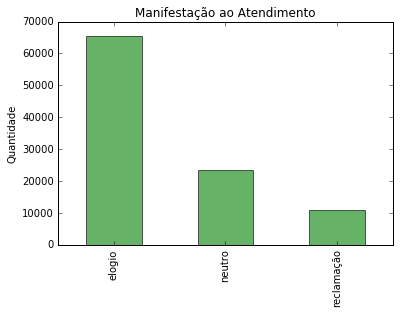

In [22]:
%matplotlib inline
plt.ylabel('Quantidade')
plt.title('Manifestação ao Atendimento')
(df_scikit['Manif-ATEN2'].value_counts()).plot(kind='bar',color='g',alpha=0.6,figsize=(6, 4))

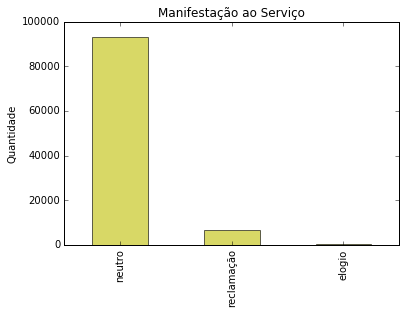

In [23]:
plt.ylabel('Quantidade')
plt.title('Manifestação ao Serviço')
(df_scikit['Manif-SERV2'].value_counts()).plot(kind='bar',color='y',alpha=0.6,figsize=(6, 4))

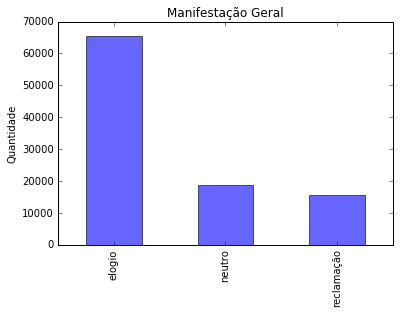

In [24]:
plt.ylabel('Quantidade')
plt.title('Manifestação Geral')
(df_scikit['label'].value_counts()).plot(kind='bar',alpha=0.6,figsize=(6, 4))

#### 2.3 - Standardization, or mean removal and variance scaling

In [25]:
print(df_scikit['nota1'].value_counts())
print(df_scikit['nota2'].value_counts())

5.0    76621
1.0     8847
4.0     6468
3.0     5215
2.0     2674
Name: nota1, dtype: int64
5.0    81058
1.0    18767
Name: nota2, dtype: int64


In [26]:
n1=(df_scikit['nota1'].values)
n2=(df_scikit['nota2'].values)

n1_scaled=n1.reshape(-1,1)
n2_scaled=n2.reshape(-1,1)

In [27]:
"""
min_max_scaler = preprocessing.MinMaxScaler()
n1_scaled = min_max_scaler.fit_transform(n1.reshape(-1,1))
n2_scaled = min_max_scaler.fit_transform(n2.reshape(-1,1))
"""

'\nmin_max_scaler = preprocessing.MinMaxScaler()\nn1_scaled = min_max_scaler.fit_transform(n1.reshape(-1,1))\nn2_scaled = min_max_scaler.fit_transform(n2.reshape(-1,1))\n'

In [28]:
unique, counts = np.unique(n1_scaled, return_counts=True)
print (np.asarray((unique, counts)).T)
unique, counts = np.unique(n2_scaled, return_counts=True)
print (np.asarray((unique, counts)).T)
print(n1_scaled.shape,"   -    ",n2_scaled.shape)

[[  1.00000000e+00   8.84700000e+03]
 [  2.00000000e+00   2.67400000e+03]
 [  3.00000000e+00   5.21500000e+03]
 [  4.00000000e+00   6.46800000e+03]
 [  5.00000000e+00   7.66210000e+04]]
[[  1.00000000e+00   1.87670000e+04]
 [  5.00000000e+00   8.10580000e+04]]
(99825, 1)    -     (99825, 1)


### 3 - Processamento - Scikit Learn

### 3.0 - CountVectorizer e TfidfTransformer - 4 cenários

In [38]:
#Binary features
count_vect = CountVectorizer(binary=True)
count_vect.fit(df_scikit['text'].values)
data1 = count_vect.transform(df_scikit['text'].values)

#bag of words features
count_vect = CountVectorizer(binary=False)
count_vect.fit(df_scikit['text'].values)
data2 = count_vect.transform(df_scikit['text'].values)

#tf features
count_vect = CountVectorizer(binary=False)
count_vect.fit(df_scikit['text'].values)
data = count_vect.transform(df_scikit['text'].values)
tf_transformer = TfidfTransformer(use_idf=False).fit(data)
data3 = tf_transformer.transform(data)

#tfidf features
count_vect = CountVectorizer(binary=False)
count_vect.fit(df_scikit['text'].values)
data = count_vect.transform(df_scikit['text'].values)
tf_transformer = TfidfTransformer(use_idf=True).fit(data)
data4 = tf_transformer.transform(data)


In [39]:
train_comments1, test_comments1, train_labels1, test_labels1 = cross_validation.train_test_split(data1, df_scikit['label'].values, test_size=0.2, random_state=0)
train_comments2, test_comments2, train_labels2, test_labels2 = cross_validation.train_test_split(data2, df_scikit['label'].values, test_size=0.2, random_state=0)
train_comments3, test_comments3, train_labels3, test_labels3 = cross_validation.train_test_split(data3, df_scikit['label'].values, test_size=0.2, random_state=0)
train_comments4, test_comments4, train_labels4, test_labels4 = cross_validation.train_test_split(data4, df_scikit['label'].values, test_size=0.2, random_state=0)

In [40]:
#Naive Bayes
clf_NB = MultinomialNB().fit(train_comments1, train_labels1)
print("Naive Bayes - Binario     :",clf_NB.score(test_comments1, test_labels1))
clf_NB = MultinomialNB().fit(train_comments2, train_labels2)
print("Naive Bayes - Bag of Words:",clf_NB.score(test_comments2, test_labels2))
clf_NB = MultinomialNB().fit(train_comments3, train_labels3)
print("Naive Bayes - TF          :",clf_NB.score(test_comments3, test_labels3))
clf_NB = MultinomialNB().fit(train_comments4, train_labels4)
print("Naive Bayes - TFIDF       :",clf_NB.score(test_comments4, test_labels4))

Naive Bayes - Binario     : 0.816478837966
Naive Bayes - Bag of Words: 0.816028049086
Naive Bayes - TF          : 0.812722263962
Naive Bayes - TFIDF       : 0.814124718257


In [41]:
#SGD
clf_SGD = SGDClassifier(loss="hinge", penalty="l2",n_iter=50)

clf_SGD.fit(train_comments1, train_labels1)
print("SGD - Binario     :",clf_SGD.score(test_comments1, test_labels1))
clf_SGD.fit(train_comments2, train_labels2)
print("SGD - Bag of Words:",clf_SGD.score(test_comments2, test_labels2))
clf_SGD.fit(train_comments3, train_labels3)
print("SGD - TF          :",clf_SGD.score(test_comments3, test_labels3))
clf_SGD.fit(train_comments4, train_labels4)
print("SGD - TFIDF       :",clf_SGD.score(test_comments4, test_labels4))

SGD - Binario     : 0.847282744803
SGD - Bag of Words: 0.847633358377
SGD - TF          : 0.840921612822
SGD - TFIDF       : 0.844928625094


In [42]:
clf_XGB=xgb.XGBClassifier(max_depth=5, learning_rate=0.05, n_estimators=100)

clf_XGB.fit(train_comments1, train_labels1)
print("XGB - Binario     :",clf_XGB.score(test_comments1, test_labels1))
clf_XGB.fit(train_comments2, train_labels2)
print("XGB - Bag of Words:",clf_XGB.score(test_comments2, test_labels2))
clf_XGB.fit(train_comments3, train_labels3)
print("XGB - TF          :",clf_XGB.score(test_comments3, test_labels3))
clf_XGB.fit(train_comments4, train_labels4)
print("XGB - TFIDF       :",clf_XGB.score(test_comments4, test_labels4))

XGB - Binario     : 0.788179313799
XGB - Bag of Words: 0.788980716253
XGB - TF          : 0.795241672928
XGB - TFIDF       : 0.795141497621


In [43]:
clf_SVM = svm.SVC(kernel='linear', C=1,cache_size=1000).fit(train_comments1, train_labels1)
print("SVM - Binario     :",clf_SVM.score(test_comments1, test_labels1))
clf_SVM = svm.SVC(kernel='linear', C=1,cache_size=1000).fit(train_comments2, train_labels2)
print("SVM - Bag of Words:",clf_SVM.score(test_comments2, test_labels2))
clf_SVM = svm.SVC(kernel='linear', C=1,cache_size=1000).fit(train_comments3, train_labels3)
print("SVM - TF          :",clf_SVM.score(test_comments3, test_labels3))
clf_SVM = svm.SVC(kernel='linear', C=1,cache_size=1000).fit(train_comments4, train_labels4)
print("SVM - TFIDF       :",clf_SVM.score(test_comments4, test_labels4))

SVM - Binario     : 0.838868019033
SVM - Bag of Words: 0.841121963436
SVM - TF          : 0.8501878287
SVM - TFIDF       : 0.846230904082


### 3.1 - Models - Cross Validation & Stratified KFold

In [133]:
count_vect = CountVectorizer()
count_vect.fit(df_scikit['text'].values)
data = count_vect.transform(df_scikit['text'].values)

#term frequency features
tf_transformer = TfidfTransformer(use_idf=False).fit(data)
data_features_tf = tf_transformer.transform(data)

In [134]:
train_comments, test_comments, train_labels, test_labels = cross_validation.train_test_split(data_features_tf, df_scikit['label'].values, test_size=0.2, random_state=0)

#### Incluindo informações adicionais de Nota1 e Nota2 como features do modelo

In [135]:
#n1=coo_matrix(df_scikit['nota1'].values)
#n2=coo_matrix(df_scikit['nota2'].values)
#n1=coo_matrix(n1)
#n2=coo_matrix(n2)
print(data_features_tf.shape)

data_features_tf2=csr_matrix(hstack([coo_matrix(data_features_tf),coo_matrix(n1_scaled)]))
data_features_tf2=csr_matrix(hstack([coo_matrix(data_features_tf2),coo_matrix(n2_scaled)]))

print(n1_scaled.shape)
print(n2_scaled.shape)
print(data_features_tf2.shape)

(99825, 27385)
(99825, 1)
(99825, 1)
(99825, 27387)


In [136]:
from sklearn import cross_validation
train_comments2, test_comments2, train_labels2, test_labels2 = cross_validation.train_test_split(data_features_tf2, df_scikit['label'].values, test_size=0.2, random_state=0)

#### 3.1.1 - Model 1 - SVM (kernel=linear)


In [89]:
clf = svm.SVC(kernel='linear', C=1,cache_size=1000).fit(train_comments, train_labels)
#clf.score(test_comments, test_labels)

In [90]:
clf2 = svm.SVC(kernel='linear', C=1,cache_size=1000).fit(train_comments2, train_labels2)
#clf2.score(test_comments2, test_labels2)

When the cv argument is an integer, cross_val_score uses the KFold or StratifiedKFold strategies by default, the latter being used if the estimator derives from ClassifierMixin.

In [103]:
n_samples=data_features_tf.shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=5, test_size=0.2, random_state=23)
scores_SVM = cross_validation.cross_val_score(clf, data_features_tf, df_scikit['label'].values , cv=cv)

In [104]:
print("Accuracy: %0.3f (+/- %0.3f)" % (scores_SVM.mean(), scores_SVM.std() * 2))
print(scores_SVM)

Accuracy: 0.851 (+/- 0.004)
[ 0.84998748  0.85369396  0.84968695  0.84883546  0.85359379]


In [76]:
n_samples=data_features_tf2.shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=5, test_size=0.2, random_state=23)
scores_SVM2 = cross_validation.cross_val_score(clf2, data_features_tf2, df_scikit['label'].values , cv=cv)

In [102]:
print("Accuracy: %0.3f (+/- %0.3f)" % (scores_SVM2.mean(), scores_SVM2.std() * 2))
print(scores_SVM2)

Accuracy: 0.868 (+/- 0.004)
[ 0.86566491  0.86947158  0.86731781  0.86751816  0.87087403]


In [78]:
docs_new=['nada a declarar','Ok','rápido e atencioso','fecharam o chamado sem me avisar. absurdo','como sempre, muito lento','não fizeram mais do que o esperado. nem satisfeito nem insatisfeito', 'depois de 5 dias me retornaram dizendo que não podiam fazer nada pelo problema!!!!']
nota1_new=coo_matrix([5.0,3.0,5.0,2.0,2.0,4.0,1.0])
nota2_new=coo_matrix([5.0,5.0,5.0,1.0,5.0,5.0,1.0])
#-------------------------------------------------------------------
counts_new = count_vect.transform(docs_new)
counts_new_tf = tf_transformer.transform(counts_new)

counts_new_tf=csr_matrix(hstack([coo_matrix(counts_new_tf),nota1_new.transpose()]))
counts_new_tf=csr_matrix(hstack([coo_matrix(counts_new_tf),nota2_new.transpose()]))

predicted = clf2.predict(counts_new_tf)

for doc,category in zip(docs_new,predicted):
    print(doc,category)

nada a declarar neutro
Ok neutro
rápido e atencioso elogio
fecharam o chamado sem me avisar. absurdo reclamação
como sempre, muito lento reclamação
não fizeram mais do que o esperado. nem satisfeito nem insatisfeito neutro
depois de 5 dias me retornaram dizendo que não podiam fazer nada pelo problema!!!! reclamação


#### 3.1.2 - Model 2 - SVM (kernel=Gaussian RBF)


In [86]:
clf3 = svm.SVC(kernel='rbf', C=1,cache_size=1000).fit(train_comments, train_labels)
#clf3.score(test_comments, test_labels)

In [87]:
clf4 = svm.SVC(kernel='rbf', C=1,cache_size=1000).fit(train_comments2, train_labels2)
#clf4.score(test_comments2, test_labels2)

In [96]:
n_samples=data_features_tf.shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=5, test_size=0.2, random_state=23)
scores_SVM3 = cross_validation.cross_val_score(clf3, data_features_tf, df_scikit['label'].values , cv=cv)

In [100]:
print("Accuracy: %0.3f (+/- %0.3f)" % (scores_SVM3.mean(), scores_SVM3.std() * 2))
print(scores_SVM3)

Accuracy: 0.654 (+/- 0.002)
[ 0.6539444   0.65609817  0.65369396  0.6539444   0.65299274]


In [98]:
n_samples=data_features_tf2.shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=5, test_size=0.2, random_state=23)
scores_SVM4 = cross_validation.cross_val_score(clf4, data_features_tf2, df_scikit['label'].values , cv=cv)

In [99]:
print("Accuracy: %0.3f (+/- %0.3f)" % (scores_SVM4.mean(), scores_SVM4.std() * 2))
print(scores_SVM4)

Accuracy: 0.781 (+/- 0.002)
[ 0.7805159   0.78292011  0.77946406  0.78161783  0.78026546]


When the cv argument is an integer, cross_val_score uses the KFold or StratifiedKFold strategies by default, the latter being used if the estimator derives from ClassifierMixin.

In [47]:
docs_new=['nada a declarar','Ok','rápido e atencioso','fecharam o chamado sem me avisar. absurdo','como sempre, muito lento','não fizeram mais do que o esperado. nem satisfeito nem insatisfeito', 'depois de 5 dias me retornaram dizendo que não podiam fazer nada pelo problema!!!!']
nota1_new=coo_matrix([5.0,3.0,5.0,2.0,2.0,4.0,1.0])
nota2_new=coo_matrix([5.0,5.0,5.0,1.0,5.0,5.0,1.0])
#-------------------------------------------------------------------
counts_new = count_vect.transform(docs_new)
counts_new_tf = tf_transformer.transform(counts_new)

counts_new_tf=csr_matrix(hstack([coo_matrix(counts_new_tf),nota1_new.transpose()]))
counts_new_tf=csr_matrix(hstack([coo_matrix(counts_new_tf),nota2_new.transpose()]))

predicted = clf4.predict(counts_new_tf)

for doc,category in zip(docs_new,predicted):
    print(doc,category)

nada a declarar elogio
Ok elogio
rápido e atencioso elogio
fecharam o chamado sem me avisar. absurdo reclamação
como sempre, muito lento reclamação
não fizeram mais do que o esperado. nem satisfeito nem insatisfeito elogio
depois de 5 dias me retornaram dizendo que não podiam fazer nada pelo problema!!!! reclamação


#### 3.1.3 - Model 3 - Naive Bayes (Multinomial Naive Bayes)


In [48]:
clf5 = MultinomialNB().fit(train_comments, train_labels)
#clf5.score(test_comments, test_labels)

In [84]:
clf6 = MultinomialNB().fit(train_comments2, train_labels2)
#clf6.score(test_comments2, test_labels2)

In [85]:
n_samples=data_features_tf.shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=5, test_size=0.2, random_state=23)
scores_NB1 = cross_validation.cross_val_score(teste, data_features_tf, df_scikit['label'].values , cv=cv)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores_NB1.mean(), scores_NB1.std() * 2))
print(scores_NB1)

Accuracy: 0.814 (+/- 0.003)
[ 0.81187077  0.81372402  0.81442524  0.81437516  0.81672928]


In [64]:
n_samples=data_features_tf2.shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=5, test_size=0.2, random_state=23)
scores_NB2 = cross_validation.cross_val_score(clf6, data_features_tf2, df_scikit['label'].values , cv=cv)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores_NB2.mean(), scores_NB2.std() * 2))
print(scores_NB2)

Accuracy: 0.813 (+/- 0.003)
[ 0.81262209  0.81432507  0.81101928  0.81537691  0.81402454]


In [57]:
docs_new=['nada a declarar','Ok','rápido e atencioso','fecharam o chamado sem me avisar. absurdo','como sempre, muito lento','não fizeram mais do que o esperado. nem satisfeito nem insatisfeito', 'depois de 5 dias me retornaram dizendo que não podiam fazer nada pelo problema!!!!']
nota1_new=coo_matrix([5.0,3.0,5.0,2.0,2.0,4.0,1.0])
nota2_new=coo_matrix([5.0,5.0,5.0,1.0,5.0,5.0,1.0])
#-------------------------------------------------------------------
counts_new = count_vect.transform(docs_new)
counts_new_tf = tf_transformer.transform(counts_new)

counts_new_tf=csr_matrix(hstack([coo_matrix(counts_new_tf),nota1_new.transpose()]))
counts_new_tf=csr_matrix(hstack([coo_matrix(counts_new_tf),nota2_new.transpose()]))

predicted = clf6.predict(counts_new_tf)

for doc,category in zip(docs_new,predicted):
    print(doc,category)

nada a declarar neutro
Ok elogio
rápido e atencioso elogio
fecharam o chamado sem me avisar. absurdo reclamação
como sempre, muito lento elogio
não fizeram mais do que o esperado. nem satisfeito nem insatisfeito neutro
depois de 5 dias me retornaram dizendo que não podiam fazer nada pelo problema!!!! reclamação


#### 3.1.4 - Model 4 - SGD (Stochastic Gradient Descent)


In [91]:
clf7 = SGDClassifier(loss="hinge", penalty="l2",n_iter=50)
clf7.fit(train_comments, train_labels)

In [92]:
clf8 = SGDClassifier(loss="hinge", penalty="l2",n_iter=50)
clf8.fit(train_comments2, train_labels2)

In [93]:
n_samples=data_features_tf.shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=5, test_size=0.2, random_state=23)
scores_SGD1 = cross_validation.cross_val_score(clf7, data_features_tf, df_scikit['label'].values , cv=cv)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores_SGD1.mean(), scores_SGD1.std() * 2))
print(scores_SGD1)

Accuracy: 0.842 (+/- 0.004)
[ 0.84007012  0.84277486  0.83931881  0.84167293  0.84452792]


In [66]:
n_samples=data_features_tf2.shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=5, test_size=0.2, random_state=23)
scores_SGD2 = cross_validation.cross_val_score(clf8, data_features_tf2, df_scikit['label'].values , cv=cv)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores_SGD2.mean(), scores_SGD2.std() * 2))
print(scores_SGD2)

Accuracy: 0.861 (+/- 0.004)
[ 0.85950413  0.8612572   0.85920361  0.86225895  0.86506386]


In [67]:
docs_new=['nada a declarar','Ok','rápido e atencioso','fecharam o chamado sem me avisar. absurdo','como sempre, muito lento','não fizeram mais do que o esperado. nem satisfeito nem insatisfeito', 'depois de 5 dias me retornaram dizendo que não podiam fazer nada pelo problema!!!!']
nota1_new=coo_matrix([5.0,3.0,5.0,2.0,2.0,4.0,1.0])
nota2_new=coo_matrix([5.0,5.0,5.0,1.0,5.0,5.0,1.0])
#-------------------------------------------------------------------
counts_new = count_vect.transform(docs_new)
counts_new_tf = tf_transformer.transform(counts_new)

counts_new_tf=csr_matrix(hstack([coo_matrix(counts_new_tf),nota1_new.transpose()]))
counts_new_tf=csr_matrix(hstack([coo_matrix(counts_new_tf),nota2_new.transpose()]))

predicted = clf8.predict(counts_new_tf)

for doc,category in zip(docs_new,predicted):
    print(doc,category)

nada a declarar neutro
Ok neutro
rápido e atencioso elogio
fecharam o chamado sem me avisar. absurdo reclamação
como sempre, muito lento reclamação
não fizeram mais do que o esperado. nem satisfeito nem insatisfeito neutro
depois de 5 dias me retornaram dizendo que não podiam fazer nada pelo problema!!!! reclamação


#### 3.1.5 - XGBoost (Extreme Gradient Boosting)
XGBoost is short for “Extreme Gradient Boosting”, where the term “Gradient Boosting” is proposed in the paper Greedy Function Approximation: A Gradient Boosting Machine, by Friedman. XGBoost is based on this original model. This is a tutorial on gradient boosted trees, and most of the content is based on these slides by the author of xgboost.

The GBM (boosted trees) has been around for really a while, and there are a lot of materials on the topic. This tutorial tries to explain boosted trees in a self-contained and principled way using the elements of supervised learning. We think this explanation is cleaner, more formal, and motivates the variant used in xgboost.

In [186]:
clf9=xgb.XGBClassifier(max_depth=5, learning_rate=0.05, n_estimators=100)
clf9.fit(train_comments, train_labels)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [95]:
clf10=xgb.XGBClassifier(max_depth=5, learning_rate=0.05, n_estimators=100)
clf10.fit(train_comments2, train_labels2)

In [187]:
n_samples=data_features_tf.shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=5, test_size=0.2, random_state=23)
scores_XGB1 = cross_validation.cross_val_score(clf9, data_features_tf, df_scikit['label'].values , cv=cv)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores_XGB1.mean(), scores_XGB1.std() * 2))
print(scores_XGB1)

Accuracy: 0.792 (+/- 0.002)
[ 0.79283747  0.79128475  0.79058352  0.79278738  0.79233659]


In [71]:
n_samples=data_features_tf2.shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=5, test_size=0.2, random_state=23)
scores_XGB2 = cross_validation.cross_val_score(clf10, data_features_tf2, df_scikit['label'].values , cv=cv)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores_XGB2.mean(), scores_XGB2.std() * 2))
print(scores_XGB2)

Accuracy: 0.838 (+/- 0.004)
[ 0.83991986  0.84127223  0.83701478  0.83506136  0.83741548]


In [72]:
docs_new=['nada a declarar','Ok','rápido e atencioso','fecharam o chamado sem me avisar. absurdo','como sempre, muito lento','não fizeram mais do que o esperado. nem satisfeito nem insatisfeito', 'depois de 5 dias me retornaram dizendo que não podiam fazer nada pelo problema!!!!']
nota1_new=coo_matrix([5.0,3.0,5.0,2.0,2.0,4.0,1.0])
nota2_new=coo_matrix([5.0,5.0,5.0,1.0,5.0,5.0,1.0])
#-------------------------------------------------------------------
counts_new = count_vect.transform(docs_new)
counts_new_tf = tf_transformer.transform(counts_new)

counts_new_tf=csr_matrix(hstack([coo_matrix(counts_new_tf),nota1_new.transpose()]))
counts_new_tf=csr_matrix(hstack([coo_matrix(counts_new_tf),nota2_new.transpose()]))

predicted = clf10.predict(counts_new_tf)

for doc,category in zip(docs_new,predicted):
    print(doc,category)

nada a declarar elogio
Ok neutro
rápido e atencioso elogio
fecharam o chamado sem me avisar. absurdo reclamação
como sempre, muito lento reclamação
não fizeram mais do que o esperado. nem satisfeito nem insatisfeito neutro
depois de 5 dias me retornaram dizendo que não podiam fazer nada pelo problema!!!! reclamação


#### 3.2 - Metrics


In [60]:
#clf = svm.SVC(kernel='linear', C=1)
#clf = clf.fit(train_comments,train_labels)
predicted5 = clf5.predict(test_comments)
print('Naive Bayes   sem features de Nota:',np.mean(predicted5 == test_labels))

Naive Bayes   sem features de Nota: 0.812722263962


In [61]:
print(metrics.classification_report(test_labels,predicted))

             precision    recall  f1-score   support

     elogio       0.89      0.98      0.93     13040
     neutro       0.62      0.33      0.43      3754
 reclamação       0.61      0.72      0.66      3171

avg / total       0.80      0.81      0.79     19965



In [62]:
print(metrics.confusion_matrix(test_labels,predicted))

[[12718   176   146]
 [ 1192  1234  1328]
 [  311   586  2274]]


In [67]:
predicted_proba5 = clf5.predict_proba(test_comments)
print ('Cross Entropy Log-loss - Naive Bayes   sem features de Nota:%.4f' % log_loss(test_labels, predicted_proba5))

Cross Entropy Log-loss - Naive Bayes   sem features de Nota:0.4149


#### Calculating Log_loss for clf2 - SVM Linear com features de Nota

In [64]:
clf2_proba = svm.SVC(kernel='linear', C=1,cache_size=1000,probability=True).fit(train_comments2, train_labels2)

In [65]:
predicted_proba2 = clf2_probaroba.predict_proba(test_comments2)

In [66]:
print ('Cross Entropy Log-loss - SVM Linear   com features de Nota: %.4f' % log_loss(test_labels2, predicted_proba2))

Cross Entropy Log-loss - SVM Linear   com features de Nota: 0.3128


#### 3.3 - Model Persistence
Após o treinamento de um modelo scikit-learn, é desejável criar formas de persistir o modelo para uso futuro, sem a necessidade de realizar o treinamento novamente.

In [29]:
def dump_model(estimator,filename):
    outputs = './outputs/'
    datafile = os.path.join(outputs,filename)
    
    joblib.dump(estimator, datafile)

In [30]:
def load_model(filename):
    outputs = './outputs/'
    datafile = os.path.join(outputs,filename)
    
    return(joblib.load(datafile))

In [33]:
dump_model(clf ,'model1a.pk1')
dump_model(clf2,'model1b.pk1')
dump_model(clf3,'model2a.pk1')
dump_model(clf4,'model2b.pk1')
dump_model(clf5,'model3a.pk1')
dump_model(clf6,'model3b.pk1')
dump_model(clf7,'model4a.pk1')
dump_model(clf8,'model4b.pk1')
dump_model(clf9, 'model5a.pk1')
dump_model(clf10,'model5b.pk1')

dump_model(train_comments,'train_comments.data')
dump_model(train_labels,'train_labels.data')
dump_model(test_comments,'test_comments.data')
dump_model(test_labels,'test_labels.data')

dump_model(train_comments2,'train_comments2.data')
dump_model(train_labels2,'train_labels2.data')
dump_model(test_comments2,'test_comments2.data')
dump_model(test_labels2,'test_labels2.data')

In [31]:
clf  = load_model('model1a.pk1')
clf2 = load_model('model1b.pk1')
clf3 = load_model('model2a.pk1')
clf4 = load_model('model2b.pk1')
clf5 = load_model('model3a.pk1')
clf6 = load_model('model3b.pk1')
clf7 = load_model('model4a.pk1')
clf8 = load_model('model4b.pk1')
clf9 = load_model('model5a.pk1')
clf10= load_model('model5b.pk1')

train_comments = load_model('train_comments.data')
train_labels   = load_model('train_labels.data')
test_comments  = load_model('test_comments.data')
test_labels    = load_model('test_labels.data') 

train_comments2 = load_model('train_comments2.data')
train_labels2   = load_model('train_labels2.data')
test_comments2  = load_model('test_comments2.data')
test_labels2    = load_model('test_labels2.data')

In [69]:
print('SVM-Linear    sem features de Nota:',clf.score(test_comments, test_labels))
print('SVM-Linear    com features de Nota:',clf2.score(test_comments2, test_labels2))
print('SVM-RBF       sem features de Nota:',clf3.score(test_comments, test_labels))
print('SVM-RBF       com features de Nota:',clf4.score(test_comments2, test_labels2))

SVM-Linear    sem features de Nota: 0.8501878287
SVM-Linear    com features de Nota: 0.8664162284
SVM-RBF       sem features de Nota: 0.65314300025
SVM-RBF       com features de Nota: 0.777210117706


In [34]:
print('Naive Bayes   sem features de Nota:', clf5.score(test_comments, test_labels))
print('Naive Bayes   com features de Nota:', clf6.score(test_comments2, test_labels2))
print('SGD           sem features de Nota:', clf7.score(test_comments, test_labels))
print('SGD           com features de Nota:', clf8.score(test_comments2, test_labels2))
print('XGB           sem features de Nota:', clf9.score(test_comments, test_labels))
print('XGB           com features de Nota:',clf10.score(test_comments2, test_labels2))

Naive Bayes   sem features de Nota: 0.812722263962
Naive Bayes   com features de Nota: 0.810017530679
SGD           sem features de Nota: 0.840821437516
SGD           com features de Nota: 0.859954921112
XGB           sem features de Nota: 0.795241672928
XGB           com features de Nota: 0.83851740546


#### 3.4 - GridSearch


In [105]:
print('SVM-Linear: ',clf.get_params())
print('SVM-Gaussian: ',clf3.get_params())
print('Naive Bayes: ',clf5.get_params())
print('SGD:',clf7.get_params())

SVM-Linear:  {'C': 1, 'tol': 0.001, 'verbose': False, 'kernel': 'linear', 'shrinking': True, 'class_weight': None, 'probability': False, 'coef0': 0.0, 'random_state': None, 'decision_function_shape': None, 'max_iter': -1, 'cache_size': 1000, 'degree': 3, 'gamma': 'auto'}
SVM-Gaussian:  {'C': 1, 'tol': 0.001, 'verbose': False, 'kernel': 'rbf', 'shrinking': True, 'class_weight': None, 'probability': False, 'coef0': 0.0, 'random_state': None, 'decision_function_shape': None, 'max_iter': -1, 'cache_size': 1000, 'degree': 3, 'gamma': 'auto'}
Naive Bayes:  {'class_prior': None, 'fit_prior': True, 'alpha': 1.0}
SGD: {'n_iter': 50, 'shuffle': True, 'epsilon': 0.1, 'power_t': 0.5, 'alpha': 0.0001, 'learning_rate': 'optimal', 'eta0': 0.0, 'class_weight': None, 'l1_ratio': 0.15, 'fit_intercept': True, 'random_state': None, 'penalty': 'l2', 'n_jobs': 1, 'average': False, 'warm_start': False, 'loss': 'hinge', 'verbose': 0}


#### 3.4.1 - GridSearch for SVM

In [16]:
param_grid = {"C": [0.5,1,2]
             }

In [17]:
# Executando Grid Search
grid_search =  GridSearchCV(clf2, param_grid=param_grid)
start = time()
grid_search.fit(test_comments2, test_labels2)

print("GridSearchCV levou %.2f segundos para %d avaliação de parameteros."% (time() - start, len(grid_search.cv_results_['params'])))

GridSearchCV levou 165.16 segundos para 3 avaliação de parameteros.


In [18]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 0.5}
0.861157024793


In [19]:
grid_search.cv_results_

{'mean_fit_time': array([ 7.0697155 ,  7.29463903,  7.92234945]),
 'mean_score_time': array([ 2.96941312,  3.05672073,  3.06332405]),
 'mean_test_score': array([ 0.86115702,  0.86100676,  0.85860255]),
 'mean_train_score': array([ 0.88572512,  0.90057614,  0.92053603]),
 'param_C': masked_array(data = [0.5 1 2],
              mask = [False False False],
        fill_value = ?),
 'params': ({'C': 0.5}, {'C': 1}, {'C': 2}),
 'rank_test_score': array([1, 2, 3], dtype=int32),
 'split0_test_score': array([ 0.85892428,  0.85922476,  0.85772236]),
 'split0_train_score': array([ 0.88789541,  0.90277256,  0.92298445]),
 'split1_test_score': array([ 0.86160781,  0.85890308,  0.85544703]),
 'split1_train_score': array([ 0.88557476,  0.90150263,  0.91923366]),
 'split2_test_score': array([ 0.86293959,  0.8648933 ,  0.86263901]),
 'split2_train_score': array([ 0.88370521,  0.89745323,  0.91938998]),
 'std_fit_time': array([ 0.2329311 ,  0.36997462,  0.16246126]),
 'std_score_time': array([ 0.071426

#### 3.5 - Voting


In [40]:
clf_voting = VotingClassifier(estimators=[('SVM-Linear', clf2), ('SGD', clf8), ('XGB', clf10)], voting='hard')

In [41]:
clf_voting.fit(train_comments2, train_labels2)

VotingClassifier(estimators=[('SVM-Linear', SVC(C=1, cache_size=1000, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)), ('SGD', SGDClassifier(alpha=0.0001, average=F...softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1))],
         n_jobs=1, voting='hard', weights=None)

In [42]:
clf_voting.score(test_comments2, test_labels2)

0.86942148760330573

#### 3.6 - Trabalhando os Dados -  Remoção de stopwords , Noise Removal, Bigrams and Ngrams


In [30]:
#Creating Commentary Text and Commentary text list from the pandas dataframe
list1 = df_scikit['text']
list1=list1.str.lower()
raw_texts=''
for i in list1:
    raw_texts += u'\n'+ i

In [31]:
print('total textos:',len(list1))
print('total chars :',len(raw_texts))

total textos: 99825
total chars : 7210752


In [32]:
def ocorrencias_palavra(expressao):
    pos = 0 
    positions = []
    while pos != -1:
        position = raw_texts.find(expressao,pos+1)
        pos = position
        positions.append(position)
    positions.pop()
    print(u'A expressão buscada ocorre {} vezes'.format(len(positions)))

In [33]:
ocorrencias_palavra('muito')
ocorrencias_palavra('o')

A expressão buscada ocorre 19183 vezes
A expressão buscada ocorre 696284 vezes


In [79]:
#Lista de Ignore words para idioma português
stop = nltk.corpus.stopwords.words('portuguese')
print(len(stop))
print(type(stop))

203
<class 'list'>


In [118]:
df_scikit['text_limpo'] = df_scikit['text']
df_scikit['text_limpo'] = df_scikit['text_limpo'].str.lower().str.split()
df_scikit['text_limpo']= df_scikit['text_limpo'].apply(lambda x: [item for item in x if item not in stop])

In [119]:
print(df_scikit['text'][0])
print(df_scikit['text_limpo'][0])

o atendimento foi ótimo. o funcionário merece um elogio
['atendimento', 'ótimo.', 'funcionário', 'merece', 'elogio']


In [120]:
df_scikit['text_limpo']=df_scikit['text_limpo'].apply(lambda x: (' '.join(x)).replace('.','').replace(',',''))

In [122]:
print(df_scikit['text'][0])
print(df_scikit['text_limpo'][0])

o atendimento foi ótimo. o funcionário merece um elogio
atendimento ótimo funcionário merece elogio


##### 3.6.1 - Testando após a remoção de stopwords


In [124]:
#bag of words features
count_vect = CountVectorizer()
count_vect.fit(df_scikit['text_limpo'].values)
data = count_vect.transform(df_scikit['text_limpo'].values)

#term frequency features
tf_transformer = TfidfTransformer(use_idf=False).fit(data)
data_features_tf = tf_transformer.transform(data)

In [125]:
from sklearn import cross_validation
train_comments, test_comments, train_labels, test_labels = cross_validation.train_test_split(data_features_tf, df_scikit['label'].values, test_size=0.2, random_state=0)

#### Incluindo informações adicionais de Nota1 e Nota2 como features do modelo

In [127]:
n1=(df_scikit['nota1'].values)
n2=(df_scikit['nota2'].values)

n1_scaled=n1.reshape(-1,1)
n2_scaled=n2.reshape(-1,1)

In [128]:
#n1=coo_matrix(df_scikit['nota1'].values)
#n2=coo_matrix(df_scikit['nota2'].values)
#n1=coo_matrix(n1)
#n2=coo_matrix(n2)
print(data_features_tf.shape)

data_features_tf2=csr_matrix(hstack([coo_matrix(data_features_tf),coo_matrix(n1_scaled)]))
data_features_tf2=csr_matrix(hstack([coo_matrix(data_features_tf2),coo_matrix(n2_scaled)]))

print(n1_scaled.shape)
print(n2_scaled.shape)
print(data_features_tf2.shape)

(99825, 28595)
(99825, 1)
(99825, 1)
(99825, 28597)


In [129]:
from sklearn import cross_validation
train_comments2, test_comments2, train_labels2, test_labels2 = cross_validation.train_test_split(data_features_tf2, df_scikit['label'].values, test_size=0.2, random_state=0)

In [136]:
clf = svm.SVC(kernel='linear', C=1,cache_size=1000).fit(train_comments, train_labels)
clf.score(test_comments, test_labels)
#0.8501878287

0.8434760831455046

In [137]:
clf2 = svm.SVC(kernel='linear', C=1,cache_size=1000).fit(train_comments2, train_labels2)
clf2.score(test_comments2, test_labels2)
#0.8664162284

0.86446280991735536

In [138]:
clf3 = svm.SVC(kernel='rbf', C=1,cache_size=1000).fit(train_comments, train_labels)
clf3.score(test_comments, test_labels)
#0.65314300025

0.65314300025043825

In [139]:
clf4 = svm.SVC(kernel='rbf', C=1,cache_size=1000).fit(train_comments2, train_labels2)
clf4.score(test_comments2, test_labels2)
#0.777210117706

0.77721011770598547

In [130]:
clf5 = MultinomialNB().fit(train_comments, train_labels)
clf5.score(test_comments, test_labels)
#0.81272226396193337

0.81031805659904832

In [131]:
clf6 = MultinomialNB().fit(train_comments2, train_labels2)
clf6.score(test_comments2, test_labels2)
#0.81001753067868776

0.80721262208865519

In [132]:
clf7 = SGDClassifier(loss="hinge", penalty="l2",n_iter=50)
clf7.fit(train_comments, train_labels)
clf7.score(test_comments, test_labels)
#0.84082143751565241

0.83951915852742298

In [133]:
clf8 = SGDClassifier(loss="hinge", penalty="l2",n_iter=50)
clf8.fit(train_comments2, train_labels2)
clf8.score(test_comments2, test_labels2)
#0.85995492111194594

0.86195842724768346

In [134]:
clf9=xgb.XGBClassifier(max_depth=5, learning_rate=0.05, n_estimators=100)
clf9.fit(train_comments, train_labels)
clf9.score(test_comments, test_labels)
#0.79524167292762338

0.79599298772852489

In [135]:
clf10=xgb.XGBClassifier(max_depth=5, learning_rate=0.05, n_estimators=100)
clf10.fit(train_comments2, train_labels2)
clf10.score(test_comments2, test_labels2)
#0.83851740545955422

0.83185574755822689

##### 3.6.2 - Testando unigrams / bigrams


In [142]:
#bag of words features
count_vect = CountVectorizer(ngram_range=(1, 2),stop_words=stop)
count_vect.fit(df_scikit['text'].values)
data = count_vect.transform(df_scikit['text'].values)

#term frequency features
tf_transformer = TfidfTransformer(use_idf=False).fit(data)
data_features_tf = tf_transformer.transform(data)

In [143]:
from sklearn import cross_validation
train_comments, test_comments, train_labels, test_labels = cross_validation.train_test_split(data_features_tf, df_scikit['label'].values, test_size=0.2, random_state=0)

#### Incluindo informações adicionais de Nota1 e Nota2 como features do modelo

In [144]:
n1=(df_scikit['nota1'].values)
n2=(df_scikit['nota2'].values)

n1_scaled=n1.reshape(-1,1)
n2_scaled=n2.reshape(-1,1)

In [145]:
#n1=coo_matrix(df_scikit['nota1'].values)
#n2=coo_matrix(df_scikit['nota2'].values)
#n1=coo_matrix(n1)
#n2=coo_matrix(n2)
print(data_features_tf.shape)

data_features_tf2=csr_matrix(hstack([coo_matrix(data_features_tf),coo_matrix(n1_scaled)]))
data_features_tf2=csr_matrix(hstack([coo_matrix(data_features_tf2),coo_matrix(n2_scaled)]))

print(n1_scaled.shape)
print(n2_scaled.shape)
print(data_features_tf2.shape)

(99825, 295596)
(99825, 1)
(99825, 1)
(99825, 295598)


In [129]:
from sklearn import cross_validation
train_comments2, test_comments2, train_labels2, test_labels2 = cross_validation.train_test_split(data_features_tf2, df_scikit['label'].values, test_size=0.2, random_state=0)

In [146]:
clf5 = MultinomialNB().fit(train_comments, train_labels)
clf5.score(test_comments, test_labels)
#0.81272226396193337

0.80075131480090156

In [147]:
clf6 = MultinomialNB().fit(train_comments2, train_labels2)
clf6.score(test_comments2, test_labels2)
#0.81001753067868776

0.80721262208865519

In [148]:
clf7 = SGDClassifier(loss="hinge", penalty="l2",n_iter=50)
clf7.fit(train_comments, train_labels)
clf7.score(test_comments, test_labels)
#0.84082143751565241

0.84057099924868517

In [149]:
clf8 = SGDClassifier(loss="hinge", penalty="l2",n_iter=50)
clf8.fit(train_comments2, train_labels2)
clf8.score(test_comments2, test_labels2)
#0.85995492111194594

0.86235912847483098

In [150]:
clf9=xgb.XGBClassifier(max_depth=5, learning_rate=0.05, n_estimators=100)
clf9.fit(train_comments, train_labels)
clf9.score(test_comments, test_labels)
#0.79524167292762338

0.79479088404708242

In [151]:
clf10=xgb.XGBClassifier(max_depth=5, learning_rate=0.05, n_estimators=100)
clf10.fit(train_comments2, train_labels2)
clf10.score(test_comments2, test_labels2)
#0.83851740545955422

0.83185574755822689

### 4 - Ocorrência de palavras (com objetivo de Visualização de dados)

In [71]:
df_scikit_pos = df_scikit[df_scikit['label'] == 'elogio']
df_scikit_neu = df_scikit[df_scikit['label'] == 'neutro']
df_scikit_neg = df_scikit[df_scikit['label'] == 'reclamação']

In [83]:
list_pos=df_scikit_pos['text'].tolist()
print(len(list_pos))
print(list_pos[1])

list_neu=df_scikit_neu['text'].tolist()
print(len(list_neu))
print(list_neu[1])

list_neg=df_scikit_neg['text'].tolist()
print(len(list_neg))
print(list_neg[1])

65404
muito bom o serviço prestado
18756
o chamado foi resolvido momentaneamente apenas. no dia seguinte o problema voltou
15665
acredito que a equipe de apoio devesse dar mais apoio, e buscar com mais insistência uma solução


In [93]:
def trata_texto(texto):
    stop = nltk.corpus.stopwords.words('portuguese')
    raw_texts=''
    
    for i in texto:
        raw_texts += u'\n'+ i
    
    texto_tratado = [w.strip(string.punctuation) for w in raw_texts.split() if w.strip(string.punctuation) not in stop]
    
    freq_words=Counter(texto_tratado)
    
    df_freq_words = pd.DataFrame(list(freq_words.items()))
    df_freq_words.index.name = u'Id'
    df_freq_words.columns= ['palavra','count']
    df_freq_words = df_freq_words.sort_values(by=u'count', ascending=False)
    
    return (df_freq_words)

In [98]:
df_freq_words_pos=trata_texto(list_pos)
df_freq_words_neu=trata_texto(list_neu)
df_freq_words_neg=trata_texto(list_neg)

In [107]:
print(df_freq_words_pos[0:5])
print(df_freq_words_neu[0:5])
print(df_freq_words_neg[0:5])

          palavra  count
Id                      
6630  atendimento  36179
1028    excelente  17181
2987        ótimo   7459
5792       rápido   7165
5388     parabéns   6807
           palavra  count
Id                       
11621     problema   3432
3124     resolvido   2093
7735   atendimento   2033
5134       chamado   1934
5612             é   1390
           palavra  count
Id                       
15327     problema   5073
10132  atendimento   3738
6755       chamado   3504
7342             é   2465
18539    atendente   2296


In [112]:
datapath = './datasets/'
outputs = './outputs/'
oplexicon = './oplexicon_v3.0/lexico_v3.0.txt'    #lexico gerado pela PUC-RS

df_o = pd.read_csv(os.path.join(datapath,oplexicon), header=None, encoding='utf-8', usecols=[0,2], names=[u'palavra',u'polaridade'])
df_o.drop_duplicates(subset=[u'palavra'], take_last=False, inplace=True)
df_o = df_o.set_index(u'palavra')
print(u'Corpus com {} palavras polarizadas'.format(len(df_o)))

Corpus com 32119 palavras polarizadas


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:6: FutureWarning: the take_last=False keyword is deprecated, use keep='first' instead


In [114]:
writer = pd.ExcelWriter('freq_words.xlsx')
df_freq_words_pos[0:50].to_excel(writer,'POS')
df_freq_words_neu[0:50].to_excel(writer,'NEU')
df_freq_words_neg[0:50].to_excel(writer,'NEG')
df_o.to_excel(writer,'lexico')
writer.save()

### 5 - Modelo binário de classificação - Elogio x Neutro/Reclamação
Se tivessemos apenas 2 classes no modelo: elogio e não-elogio

In [140]:
#Função para separar os registros em: elogio e não-elogio
#Input : dataframe e campo 'label'
#Output: label tratado
def setmanifestacao_binario (DF,X):
    positivo=["elogio","agradecimento"]
    neutro  =["neutro","sugestão"]
    negativo=["reclamação","insatisfeito","não-resolvido"]
    valido=positivo+neutro+negativo

    if   (str.lower(X) in negativo):
        return "não-elogio"
    elif (str.lower(X) in positivo):
        return "elogio"
    elif (str.lower(X) in neutro):
        return "não-elogio"
    elif (str.lower(X) not in valido):
        return "invalido"
    else:
        return "erro"

In [141]:
df_scikit["label_binario"]=df_scikit.apply(lambda row: setmanifestacao_binario(df_scikit,row["label"]), axis=1)

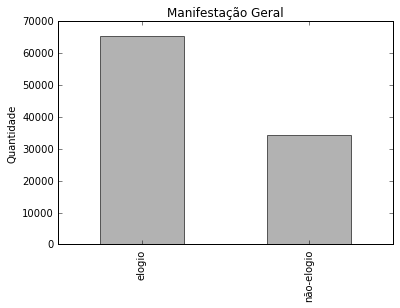

In [142]:
plt.ylabel('Quantidade')
plt.title('Manifestação Geral')
(df_scikit['label_binario'].value_counts()).plot(kind='bar',color='gray',alpha=0.6,figsize=(6, 4))

#### 5.1 - Processamento - Scikit Learn

In [143]:
#bag of words features
count_vect = CountVectorizer()
count_vect.fit(df_scikit['text'].values)
data = count_vect.transform(df_scikit['text'].values)

#term frequency features
tf_transformer = TfidfTransformer(use_idf=False).fit(data)
data_features_tf = tf_transformer.transform(data)

In [144]:
from sklearn import cross_validation
train_comments_bin, test_comments_bin, train_labels_bin, test_labels_bin = cross_validation.train_test_split(data_features_tf, df_scikit['label_binario'].values, test_size=0.2, random_state=0)

#### Incluindo informações adicionais de Nota1 e Nota2 como features do modelo

In [145]:
#n1=coo_matrix(df_scikit['nota1'].values)
#n2=coo_matrix(df_scikit['nota2'].values)
#n1=coo_matrix(n1)
#n2=coo_matrix(n2)
print(data_features_tf.shape)

data_features_tf2=csr_matrix(hstack([coo_matrix(data_features_tf),coo_matrix(n1_scaled)]))
data_features_tf2=csr_matrix(hstack([coo_matrix(data_features_tf2),coo_matrix(n2_scaled)]))

print(n1_scaled.shape)
print(n2_scaled.shape)
print(data_features_tf2.shape)

(99825, 27385)
(99825, 1)
(99825, 1)
(99825, 27387)


In [146]:
from sklearn import cross_validation
train_comments2_bin, test_comments2_bin, train_labels2_bin, test_labels2_bin = cross_validation.train_test_split(data_features_tf2, df_scikit['label_binario'].values, test_size=0.2, random_state=0)

#### 5.1.1 - Model 1 - SVM (kernel=linear)


In [140]:
clf_bin = svm.SVC(kernel='linear', C=1,cache_size=1000).fit(train_comments_bin, train_labels_bin)
clf_bin.score(test_comments_bin, test_labels_bin)

0.93979464062108686

In [141]:
clf2_bin = svm.SVC(kernel='linear', C=1,cache_size=1000).fit(train_comments2_bin, train_labels2_bin)
clf2_bin.score(test_comments2_bin, test_labels2_bin)

0.94375156523916859

In [220]:
clf_bin = svm.SVC(kernel='linear', C=1,cache_size=1000)
n_samples=data_features_tf.shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=5, test_size=0.2, random_state=23)
scores_SVM = cross_validation.cross_val_score(clf_bin, data_features_tf, df_scikit['label_binario'].values , cv=cv)

In [221]:
print("Accuracy: %0.3f (+/- %0.3f)" % (scores_SVM.mean(), scores_SVM.std() * 2))
print(scores_SVM)

Accuracy: 0.941 (+/- 0.004)
[ 0.94134736  0.94059604  0.93784122  0.94039569  0.94340095]


In [222]:
clf_bin = svm.SVC(kernel='linear', C=1,cache_size=1000)
n_samples=data_features_tf2.shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=5, test_size=0.2, random_state=23)
scores_SVM2 = cross_validation.cross_val_score(clf_bin, data_features_tf2, df_scikit['label_binario'].values , cv=cv)

In [223]:
print("Accuracy: %0.3f (+/- %0.3f)" % (scores_SVM2.mean(), scores_SVM2.std() * 2))
print(scores_SVM2)

Accuracy: 0.945 (+/- 0.003)
[ 0.94525419  0.94420235  0.94295016  0.94435262  0.94680691]


#### 5.1.2 - Model 2 - SVM (kernel=Gaussian RBF)


In [142]:
clf3_bin = svm.SVC(kernel='rbf', C=1,cache_size=1000).fit(train_comments_bin, train_labels_bin)
clf3_bin.score(test_comments_bin, test_labels_bin)

0.65314300025043825

In [143]:
clf4_bin = svm.SVC(kernel='rbf', C=1,cache_size=1000).fit(train_comments2_bin, train_labels2_bin)
clf4_bin.score(test_comments2_bin, test_labels2_bin)

0.86190833959429003

In [231]:
clf3_bin = svm.SVC(kernel='rbf', C=1,cache_size=1000)
n_samples=data_features_tf.shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=5, test_size=0.2, random_state=23)
scores_SVM3 = cross_validation.cross_val_score(clf3_bin, data_features_tf, df_scikit['label_binario'].values , cv=cv)

In [ ]:
print("Accuracy: %0.3f (+/- %0.3f)" % (scores_SVM3.mean(), scores_SVM3.std() * 2))
print(scores_SVM3)

In [233]:
clf3_bin = svm.SVC(kernel='rbf', C=1,cache_size=1000)
n_samples=data_features_tf2.shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=5, test_size=0.2, random_state=23)
scores_SVM4= cross_validation.cross_val_score(clf3_bin, data_features_tf2, df_scikit['label_binario'].values , cv=cv)

KeyboardInterrupt: 

In [ ]:
print("Accuracy: %0.3f (+/- %0.3f)" % (scores_SVM4.mean(), scores_SVM4.std() * 2))
print(scores_SVM4)

#### 5.1.3 - Model 3 - Naive Bayes (Multinomial Naive Bayes)


In [ ]:
clf5_bin = MultinomialNB().fit(train_comments_bin, train_labels_bin)
clf5_bin.score(test_comments_bin, test_labels_bin)

In [229]:
clf6_bin = MultinomialNB().fit(train_comments2_bin, train_labels2_bin)
clf6_bin.score(test_comments2_bin, test_labels2_bin)

0.90172802404207364

In [147]:
n_samples=data_features_tf.shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=5, test_size=0.2, random_state=23)
scores_NB1 = cross_validation.cross_val_score(teste, data_features_tf, df_scikit['label_binario'].values , cv=cv)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores_NB1.mean(), scores_NB1.std() * 2))
print(scores_NB1)

Accuracy: 0.917 (+/- 0.002)
[ 0.9172552   0.9172552   0.91635362  0.91905835  0.91735537]


In [148]:
n_samples=data_features_tf2.shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=5, test_size=0.2, random_state=23)
scores_NB2 = cross_validation.cross_val_score(clf6, data_features_tf2, df_scikit['label_binario'].values , cv=cv)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores_NB2.mean(), scores_NB2.std() * 2))
print(scores_NB2)

Accuracy: 0.904 (+/- 0.003)
[ 0.90493363  0.9046832   0.90192837  0.90663661  0.90398197]


#### 5.1.4 - Model 4 - SGD (Stochastic Gradient Descent)


In [191]:
clf7_bin = SGDClassifier(loss="hinge", penalty="l2",n_iter=50)
print(clf7_bin)
clf7_bin.fit(train_comments_bin, train_labels_bin)
clf7_bin.score(test_comments_bin, test_labels_bin)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)


0.93122965189080886

In [192]:
clf8_bin = SGDClassifier(loss="hinge", penalty="l2",n_iter=50)
print(clf8_bin)
clf8_bin.fit(train_comments2_bin, train_labels2_bin)
clf8_bin.score(test_comments2_bin, test_labels2_bin)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)


0.93388429752066116

In [193]:
n_samples=data_features_tf.shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=5, test_size=0.2, random_state=23)
scores_SGD1 = cross_validation.cross_val_score(clf7_bin, data_features_tf, df_scikit['label_binario'].values , cv=cv)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores_SGD1.mean(), scores_SGD1.std() * 2))
print(scores_SGD1)

Accuracy: 0.932 (+/- 0.002)
[ 0.93298272  0.93238167  0.93042825  0.93233158  0.93318307]


In [194]:
n_samples=data_features_tf2.shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=5, test_size=0.2, random_state=23)
scores_SGD2 = cross_validation.cross_val_score(clf8_bin, data_features_tf2, df_scikit['label_binario'].values , cv=cv)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores_SGD2.mean(), scores_SGD2.std() * 2))
print(scores_SGD2)

Accuracy: 0.935 (+/- 0.003)
[ 0.93288254  0.9358878   0.93613824  0.93769096  0.93373403]


#### 5.1.5 - XGBoost (Extreme Gradient Boosting)
XGBoost is short for “Extreme Gradient Boosting”, where the term “Gradient Boosting” is proposed in the paper Greedy Function Approximation: A Gradient Boosting Machine, by Friedman. XGBoost is based on this original model. This is a tutorial on gradient boosted trees, and most of the content is based on these slides by the author of xgboost.

In [214]:
clf9_bin=xgb.XGBClassifier(max_depth=5, learning_rate=0.05, n_estimators=100)
clf9_bin.fit(train_comments_bin, train_labels_bin)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [215]:
clf10_bin=xgb.XGBClassifier(max_depth=5, learning_rate=0.05, n_estimators=100)
clf10_bin.fit(train_comments2_bin, train_labels2_bin)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [216]:
n_samples=data_features_tf.shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=5, test_size=0.2, random_state=23)
scores_XGB1 = cross_validation.cross_val_score(clf9_bin, data_features_tf, df_scikit['label_binario'].values , cv=cv)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores_XGB1.mean(), scores_XGB1.std() * 2))
print(scores_XGB1)

Accuracy: 0.908 (+/- 0.005)
[ 0.9054846   0.90648635  0.90959179  0.90683696  0.91184573]


In [218]:
n_samples=data_features_tf2.shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=5, test_size=0.2, random_state=23)
scores_XGB2 = cross_validation.cross_val_score(clf10_bin, data_features_tf2, df_scikit['label_binario'].values , cv=cv)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores_XGB2.mean(), scores_XGB2.std() * 2))
print(scores_XGB2)

Accuracy: 0.911 (+/- 0.004)
[ 0.91394941  0.91304783  0.90899073  0.90934135  0.91059354]


#### 5.2 - Metrics


In [207]:
predicted_bin = clf8_bin.predict(test_comments2_bin)
print('SGD   com features de Nota:',np.mean(predicted_bin == test_labels2_bin))

SGD   com features de Nota: 0.935336839469


In [208]:
print(metrics.classification_report(test_labels2_bin,predicted_bin))

             precision    recall  f1-score   support

     elogio       0.94      0.96      0.95     13040
 não-elogio       0.93      0.88      0.90      6925

avg / total       0.94      0.94      0.93     19965



In [209]:
print(metrics.confusion_matrix(test_labels2_bin,predicted_bin))

[[12578   462]
 [  829  6096]]


##### Using calc_proba

In [214]:
clf8_bin_proba = SGDClassifier(loss='log',penalty="l2",n_iter=50)
clf8_bin_proba.fit(train_comments2_bin, train_labels2_bin)
#clf8_bin.score(test_comments2_bin, test_labels2_bin)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=50, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [215]:
predicted_bin_proba = clf8_bin_proba.predict_proba(test_comments2)

In [221]:
print(predicted_bin_proba)

[[  1.03306986e-01   8.96693014e-01]
 [  8.56854656e-01   1.43145344e-01]
 [  9.61400676e-01   3.85993238e-02]
 ..., 
 [  6.26116829e-04   9.99373883e-01]
 [  2.63362362e-01   7.36637638e-01]
 [  9.36002871e-01   6.39971291e-02]]


In [228]:
y_score=[row[0] for row in predicted_bin_proba]
#y_score - Probabilidade do registro ser 'elogio'
print(len(y_score))
print(y_score[0:10])

19965
[0.10330698619630574, 0.85685465562865026, 0.96140067619865199, 0.99728966859886814, 0.98187650740831112, 0.96030258245880407, 0.036226531399721207, 0.034834140375763156, 0.0011605388331890065, 0.99728966859886814]


#### 5.3 - RoC Curve 
“A receiver operating characteristic (ROC), or simply ROC curve, is a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. It is created by plotting the fraction of true positives out of the positives (TPR = true positive rate) vs. the fraction of false positives out of the negatives (FPR = false positive rate), at various threshold settings. TPR is also known as sensitivity, and FPR is one minus the specificity or true negative rate.”

In [229]:
print(len(test_labels2_bin))
print(test_labels2_bin)

y_true=np.copy(test_labels2_bin)
y_true[y_true == 'elogio'] = 1
y_true[y_true == 'não-elogio'] = 0

y_true=y_true.astype(np.int)
        
print(y_true)

19965
['não-elogio' 'elogio' 'não-elogio' ..., 'não-elogio' 'não-elogio' 'elogio']
[0 1 0 ..., 0 0 1]


In [230]:
fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)

In [231]:
print(fpr)
print(tpr)
print(thresholds)

[ 0.          0.          0.         ...,  0.99956679  0.9998556   1.        ]
[  7.66871166e-05   3.83435583e-04   6.90184049e-04 ...,   1.00000000e+00
   1.00000000e+00   1.00000000e+00]
[  9.99895118e-01   9.99710804e-01   9.99700970e-01 ...,   2.01143965e-04
   1.95269232e-04   1.79677417e-04]


In [235]:
roc_auc=auc(fpr,tpr)

In [232]:
roc_auc_score(y_true, y_score)

0.98073869903213651

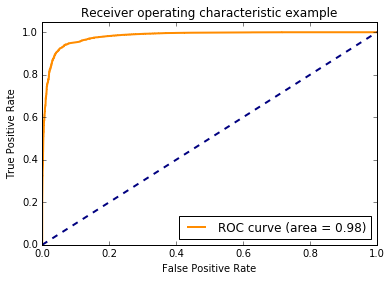

In [237]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### 6 - Exportação de dados

In [90]:
"""
predicted = clf.predict(data_features_tf[:,:])
df_scikit["predicted"]=predicted

writer = pd.ExcelWriter('output.xlsx')
df_scikit.to_excel(writer,'Sheet1')
writer.save()
"""

'\npredicted = clf.predict(data_features_tf[:,:])\ndf_scikit["predicted"]=predicted\n\nwriter = pd.ExcelWriter(\'output.xlsx\')\ndf_scikit.to_excel(writer,\'Sheet1\')\nwriter.save()\n'

In [121]:
#Função para INSERT na tabela TESTE no banco de dados
#Input : Ponteiro first_row_ID, indicando onde deve ser feito o INSERT na tabela TESTE 
#Output: Ponteiro com a nova posição após o último INSERT

def Insertdata2(first_row_ID,dict1):
    db = sqlite3.connect('projeto.db')
    cursor = db.cursor()
    i=first_row_ID+1
    for com,id_inc,data,cat,n1,n2,nivel1,aten,serv in map(lambda *a: a,*zip(*itertools.zip_longest(dict1.get('Comentário'),dict1.get('Número do Incidente'),dict1.get('Data da Resposta'),dict1.get('Manifestação Ajustada'),dict1.get('Nota Questão 1'),dict1.get('Nota Questão 2'),dict1.get('Nível 1'),dict1.get('Manifestação ao Atendimento'),dict1.get('Manifestação ao Serviço')))):
        cursor.execute("INSERT INTO TESTE (ID,IDINC,DATA,COMENTARIO,NOTA1,NOTA2,NIVEL1,MANIFESTACAO,MANIFATEN,MANIFSERV) VALUES (?,?,?,?,?,?,?,?,?,?)",(i, id_inc,data, com, n1, n2, nivel1, cat,aten,serv))
        i=i+1
    db.commit()

    #LAST ROW ID
    last_row_ID = cursor.lastrowid

    db.close()
    
    return(last_row_ID)

In [122]:
#DROP
db = sqlite3.connect('projeto.db')
querySQL = db.execute("DROP TABLE TESTE")
db.commit()
db.close()

In [123]:
#CREATE TABLE
#Comando para criar a tabela no banco de dados. Só precisa ser executada uma única vez


db = sqlite3.connect('projeto.db')
db.execute('''CREATE TABLE TESTE
       (ID INT PRIMARY KEY    NOT NULL,
       IDINC           CHAR(20),
       DATA            DATE,
       COMENTARIO      TEXT,
       NOTA1           FLOAT,
       NOTA2           FLOAT,
       NIVEL1          TEXT,
       MANIFESTACAO    CHAR(20),
       MANIFATEN       CHAR(20),
       MANIFSERV       CHAR(20));''')
db.close()

In [124]:
#MaxID
db = sqlite3.connect('projeto.db')
cursor = db.execute('SELECT max(ID) FROM TESTE')
MaxID = cursor.fetchone()[0]

try:
    val = int(MaxID)
except:
    MaxID=0
    
print(MaxID)
db.close()

0


In [125]:
lista_csv2=['2016.07-teste.csv']
for doc in lista_csv2:
    dict2=Createdict(doc)
    MaxID=Insertdata2(MaxID,dict2)
    print(MaxID)

4720


In [126]:
#Recuperando dados do banco de dados através do comando SELECT e armazenando em um Dictionary

dict2=defaultdict(list)

db = sqlite3.connect('projeto.db')
db.row_factory = sqlite3.Row
cursor =db.cursor()

querySQL = cursor.execute("SELECT ID,IDINC,DATA,COMENTARIO,NOTA1,NOTA2,MANIFESTACAO,MANIFATEN,MANIFSERV,NIVEL1 from TESTE")

for row in querySQL:
    dict2['ID'].append(row[0])
    dict2['Número do Incidente'].append(row[1])
    dict2['Data'].append(row[2])
    dict2['Comentário'].append(row[3])
    dict2['Nota Questão 1'].append(row[4])
    dict2['Nota Questão 2'].append(row[5])
    dict2['Manifestação Ajustada'].append(row[6])
    dict2['Manifestação ao Atendimento'].append(row[7])
    dict2['Manifestação ao Serviço'].append(row[8])
    dict2['Nível 1'].append(row[9])
    
db.close()

In [127]:
#Processamento - STRIP-remove caracteres, LOWER-transforma caracteres em minúsculo e SPLIT-Separa as palavras no "Comentário"
words2 = [(i.strip('.,').lower().split(),category,n1,n2,m1,m2,ID,data,id_inc,nivel1)
for i,category,n1,n2,m1,m2,ID,data,id_inc,nivel1 in map(lambda *a: a,*zip(*itertools.zip_longest(dict2.get('Comentário'),dict2.get('Manifestação Ajustada'),dict2.get('Nota Questão 1'),dict2.get('Nota Questão 2'),dict2.get('Manifestação ao Atendimento'),dict2.get('Manifestação ao Serviço'),dict2.get('ID'),dict2.get('Data'),dict2.get('Número do Incidente'),dict2.get('Nível 1'))))]


In [128]:
#Transformando DE: Dictionary --> PARA: pandas Dataframe
rows=[]

for item in words2:
    rows.append({'text':" ".join(item[0]),'label':item[1],'nota1':item[2],'nota2':item[3],'Manif-ATEN':item[4],'Manif-SERV':item[5],'ID':item[6],'Data':item[7],'Número do Incidente':item[8],'Nível 1':item[9]})
df_minority=pd.DataFrame(rows)

In [129]:
print("Total:       ",len(df_minority.index))
print(df_minority['label'].value_counts())

Total:        4720
elogio        3027
neutro        1217
reclamação     476
Name: label, dtype: int64


In [130]:
#Tratando pesquisas de satisfação com campos não preenchidos. alterar para nota=3 ou nota=1 no caso de nao respondido
df_minority['nota1']=(df_minority.fillna(value=3)['nota1'].astype(np.float))
df_minority['nota2']=(df_minority.fillna(value=1)['nota2'].astype(np.float))

In [131]:
df_minority["Manif-ATEN2"]=df_minority.apply(lambda row: setmanifestacao2(df_minority,row["Manif-ATEN"]), axis=1)
df_minority["Manif-SERV2"]=df_minority.apply(lambda row: setmanifestacao2(df_minority,row["Manif-SERV"]), axis=1)

#### Preparação e execução do algoritmo de machine learning

In [132]:
count_vect = CountVectorizer()
count_vect.fit(df_scikit['text'].values)

data2 = count_vect.transform(df_minority['text'].values)

#term frequency features
tf_transformer = TfidfTransformer(use_idf=False).fit(data2)
data_features_tf = tf_transformer.transform(data2)

In [133]:
n1=coo_matrix(df_minority['nota1'].values)
n2=coo_matrix(df_minority['nota2'].values)
print(data_features_tf.shape)

data_features_tf=csr_matrix(hstack([coo_matrix(data_features_tf),n1.transpose()]))
data_features_tf=csr_matrix(hstack([coo_matrix(data_features_tf),n2.transpose()]))


print(n1.transpose().shape)
print(n2.transpose().shape)
print(data_features_tf.shape)

(4720, 27385)
(4720, 1)
(4720, 1)
(4720, 27387)


In [138]:
predicted = clf8.predict(data_features_tf[:,:])
print(np.mean(predicted == df_minority['label'][:].values))

0.85063559322


In [135]:
print(metrics.confusion_matrix(df_minority['label'][:].values,predicted))

[[2951   64   12]
 [ 112  763  342]
 [  17   55  404]]


In [136]:
df_minority[0:1]

,Data,ID,Manif-ATEN,Manif-SERV,Nível 1,Número do Incidente,label,nota1,nota2,text,Manif-ATEN2,Manif-SERV2
0,7/1/2016 9:04,1,Reclamação,Reclamação,APLICACOES DE NEGOCIO,INC000025504474,reclamação,1.0,1.0,demora de 4 meses para o envio de uma solução ...,reclamação,reclamação


In [137]:
df_minority["predicted"]=predicted
df_minority = df_minority[['Número do Incidente','label','predicted', 'nota1', 'nota2', 'text']]
df_minority.columns=['Número do Incidente','label','predicted', 'Nota1', 'Nota2', 'Comentário']
writer = pd.ExcelWriter('output-clf2.xlsx')
df_minority.to_excel(writer,'Sheet1')
writer.save()